## Challenge: Build your own NLP model  
## Kevin Hahn  

<b>For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing  
2. Create features using two different NLP methods: For example, BoW vs tf-idf.  
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.  
4. Assess your models using cross-validation and determine whether one model performed better.  
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.  
</b>  

For this challenge I used Thornton W. Burgess's <i>The Adventures of Buster Bear</i> to practice building a NLP model. I also included the Jane Austen novels <i>Sense and Sensibility</i> and <i>Persuasion</i> as well as Lewis Carroll's <i>Alice in Wonderland</i> to check for accuracy of a model that would be identifying the correct author.  

First I cleaned the data and removed excess characters that were not textual information from each corpus. 

I used the tf-idf on the text itself which performed very strongly with minimal hyperparameter optimization. Initially I applied the tf-idf method to reduce the feature set to 130 which explained 98.32% of the variance as-is. From the results of this I reduced the feature set even further to 49 features. The Tf_idf vector identified characteristic words such as 'blacky,' 'crow,' 'tree,' 'green,' 'forest,' 'farmer,' 'brown,' and 'eyes' and the 49-feature model explained 99.97% of the variance in the corpus.  

From there I split each of the texts into sentences and amalgamated all four texts into a dataframe with the sentences and their author/text source in neighboring cells. Then, I performed the bag of words method with 500 top identified words and a 60/40 train/test split. I used the newly created feature set and ran Random Forest Classifier and Logistic Regression model which reported accuracy ratings of identifying the correct author in the low 90% range.  

Next, I increased the word count (number of most commonly used words) used in the bag of words method and increased the size of the train group to 80% of the data. With a 80/20 train/test split, the Random Forest Classifier model found an accuracy rating of 98.98% for the training set and 94.01% for the test set. Logistic Regression performed similarly with an accuracy rating of 97.03% for the training data and 94.71% for the test data.  

Cross-validation with 5 k-folds of these two supervised machine learning methods found strong accuracy ratings of 93% +/- 2% for the Random Forest Classifier and 94% +/- 1% for the Logistic Regression model. Overall, the Logistic Regression model seemed to perform better at accurately identifying the correct author (Burgess, Carroll, or Austen) and with repeated tests through cross-validation the Logit Regression method had lower variability with each iteration of the model.

In [1]:
import nltk
# nltk.download()

In [130]:
import numpy as np
import pandas as pd
import scipy
import spacy
nlp = spacy.load('en')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import gutenberg, stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import gensim
from gensim.models import word2vec
from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

%matplotlib inline


In [3]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [6]:
emma=gutenberg.paras('austen-emma.txt')


In [10]:
caesar=gutenberg.raw('shakespeare-caesar.txt')

In [78]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')
sense = gutenberg.raw('austen-sense.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
sense = re.sub(r'Chapter .*', '', sense)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)
sense = text_cleaner(sense)

In [12]:
brown=gutenberg.raw('burgess-busterbrown.txt')

In [13]:
brown

'[The Adventures of Buster Bear by Thornton W. Burgess 1920]\r\n\r\nI\r\n\r\nBUSTER BEAR GOES FISHING\r\n\r\n\r\nBuster Bear yawned as he lay on his comfortable bed of leaves and\r\nwatched the first early morning sunbeams creeping through the Green\r\nForest to chase out the Black Shadows. Once more he yawned, and slowly\r\ngot to his feet and shook himself. Then he walked over to a big\r\npine-tree, stood up on his hind legs, reached as high up on the trunk of\r\nthe tree as he could, and scratched the bark with his great claws. After\r\nthat he yawned until it seemed as if his jaws would crack, and then sat\r\ndown to think what he wanted for breakfast.\r\n\r\nWhile he sat there, trying to make up his mind what would taste best, he\r\nwas listening to the sounds that told of the waking of all the little\r\npeople who live in the Green Forest. He heard Sammy Jay way off in the\r\ndistance screaming, "Thief! Thief!" and grinned. "I wonder," thought\r\nBuster, "if some one has stolen S

In [75]:
brown=gutenberg.paras('burgess-busterbrown.txt')
#processing
brown_paras=[]
for paragraph in brown:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    para=[re.sub(r'[\[].*?[\]]', '', word) for word in para]
#     para=[re.sub(r'\\', '', word) for word in para]
#     para=[re.sub(r"[( \' )]", '', word) for word in para]
#     para=[re.sub(" ' ", "'", word) for word in para]
    
    # strip the white space next to an apostrophe
    # close the gap between words when replacing quotes/apostrophes in text
    
    
    
#     para=[re.sub(r" \' ", '', word) for word in para]
#     para=[re.sub(r'\'', '', word) for word in para]
#     para=[re.sub(r' m ',"'", word) for word in para]

    #Forming each paragraph into a string and adding it to the list of strings.
    brown_paras.append(' '.join(para))

# print(brown_paras[0:40])
print(brown_paras[7])

" I ' m going fishing ," said he in his deep grumbly - rumbly voice to no one in particular .


In [ ]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
sense_sents = [[sent, "Austen"] for sent in sense_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents + sense_sents)
sentences.head(10)

In [5]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#splitting into training and test sets
X_train, X_test= train_test_split(brown_paras,test_size=0.20, random_state=100)

#Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 216
Original sentence: " Can you tell me the difference between the fish that you haven  t caught and the foolish green flies that I haven  t caught ?"
Tf_idf vector: {'green': 0.27889237135670453, 'tell': 0.34949569359139165, 'fish': 0.30986729322907802, 'caught': 0.72078974064221013, 'foolish': 0.42955350741429887}


In [6]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

### This is the part you cross validate


# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 98.3217475606
Component 0:
LITTLE JOE OTTER GETS EVEN WITH BUSTER BEAR                                                                                                                                                                                                                                                  0.780510
BUSTER BEAR IS GREATLY PUZZLED                                                                                                                                                                                                                                                               0.611552
LITTLE JOE OTTER SUPPLIES BUSTER BEAR WITH A BREAKFAST                                                                                                                                                                                                                                       0.609270
Little Joe Otter looked around at all the eage

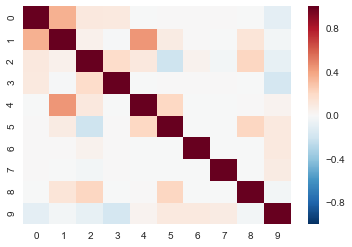

Key:
0 Blacky didn  t know what to make of it .
1 Now Farmer Brown  s boy didn  t know that Buster Bear had come down to the Green Forest to live .
2 XXIII
3 Sammy  s cousin , Blacky the Crow , just happened to be flying along the edge of the Old Pasture , and the minute he heard Sammy  s voice , he turned and flew over to see what it was all about .
4 You see , it was the most exciting moment ever was in the Green Forest .
5 " Can you tell me the difference between the fish that you haven  t caught and the foolish green flies that I haven  t caught ?"
6 Who makes an enemy a friend , To fear and worry puts an end .
7 That  s a funny thing for hair to do  rise up all of a sudden  isn  t it ?
8 " Let  s all go together and tell Buster Bear how much obliged we are for what he has done ," proposed Jerry Muskrat .
9 XIX


In [7]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


In [8]:
X_test_tfidf = vectorizer.fit_transform(X_test)
print("Number of features: %d" % X_test_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n = X_test_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara[5])


#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(39)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Number of features: 49
Original sentence: Ever since it was light enough to see at all , Blacky the Crow had been sitting in the top of the tallest tree on the edge of the Green Forest nearest to Farmer Brown  s house , and never for an instant had he taken his eyes from Farmer Brown  s back door .
Tf_idf vector: {'blacky': 0.2682715104604117, 'crow': 0.2682715104604117, 'tree': 0.30860234783690438, 'green': 0.28588919810363994, 'forest': 0.28588919810363994, 'farmer': 0.5077536230708265, 'brown': 0.5077536230708265, 'eyes': 0.28588919810363994}
Percent variance captured by all components: 99.9714641686
Component 0:
BUSTER BEAR HAS A FIT OF TEMPER                                                                                                                                                  0.802645
Buster Bear was in a terrible temper .                                                                                                                                           0.802645
" I 

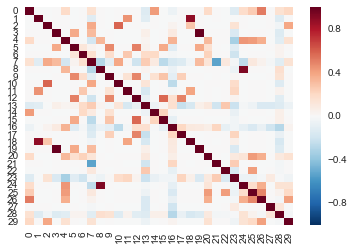

Key:
0 A dozen times a day Buster would hear them screaming this .
1 Reddy Fox rolled his lips back in an unpleasant grin .
2 " Didn  t he catch my fish and eat them ?"
3 BLACKY THE CROW TELLS HIS PLAN
4 BUSTER BEAR HAS A FINE TIME
5 Ever since it was light enough to see at all , Blacky the Crow had been sitting in the top of the tallest tree on the edge of the Green Forest nearest to Farmer Brown  s house , and never for an instant had he taken his eyes from Farmer Brown  s back door .
6 So now , as he sat in the top of the Big Hickory - tree beside the Smiling Pool and looked down on all the little people gathered there , he was very happy .
7 " Chug - a - rum !"
8 " Now I wonder who was so thoughtful as to leave this fine breakfast ready for me ," said he out loud .
9 You see , Farmer Brown  s boy was just beginning to understand something that Peter Rabbit and the other little people of the Green Meadows and the Green Forest learned almost as soon as they learned to walk , that if 

In [9]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:30,0:30]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(30))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(30):
    print(i,sim_matrix.index[i])

In [14]:
brown_everything = " ".join(brown_paras)

In [79]:
brown_doc = nlp(brown_everything)
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)
sense_doc = nlp(sense)

In [133]:
brown_doc[0:200]

[ The Adventures of Buster Bear by Thornton W . Burgess 1920 ] I BUSTER BEAR GOES FISHING Buster Bear yawned as he lay on his comfortable bed of leaves and watched the first early morning sunbeams creeping through the Green Forest to chase out the Black Shadows . While he sat there , trying to make up his mind what would taste best , he was listening to the sounds that told of the waking of all the little people who live in the Green Forest . He heard Chatterer the Red Squirrel scolding as fast as he could make his tongue go and working himself into a terrible rage . He heard Blacky the Crow cawing at the top of his lungs , and he knew by the sound that Blacky was getting into mischief of some kind . " I  m going fishing ," said he in his deep grumbly - rumbly voice to no one in particular . He shuffled along over to the Laughing Brook , and straight to a little pool of which he knew , and as he drew near he took the greatest care not to make the teeniest ,

In [18]:
sentences = []
for sentence in brown_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)

print(sentences[20])
print('We have {} sentences and {} tokens.'.format(len(sentences), len(brown_everything)))

['sure', 'buster', 'bear', 'sit', 'close', 'little', 'pool', 'look', 'intently']
We have 203 sentences and 21988 tokens.


In [28]:
model = word2vec.Word2Vec(
    sentences,
    seed=27,       # Random seed
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [29]:
vocab = model.wv.vocab.keys()

In [33]:
#Most common vocabulary in Buster Bear
print(vocab)
print(len(vocab))

dict_keys(['buster', 'bear', 'go', 'green', 'forest', 'good', 'tell', 'little', 'hear', 'blacky', 'know', ' ', 'say', 'pool', 'great', 'joe', 'otter', 'fish', 's', 't', 'billy', 'mink', 'catch', 'come', 'big', 'time', 'away', 'didn', 'look', 'long', 'think', 'grandfather', 'frog', 'thief', 'thing', 'farmer', 'brown', 'boy', 'see', 'sammy', 'jay', 'berry'])
42


In [113]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2500)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
brownwords = bag_of_words(brown_doc)
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)
sensewords = bag_of_words(sense_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [114]:
# Group into sentences.
brown_sents = [[sent, "Burgess"] for sent in brown_doc.sents]
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
sense_sents = [[sent, "Austen"] for sent in sense_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(brown_sents + alice_sents + persuasion_sents + sense_sents)
sentences.head(10)

,0,1
0,"([, The, Adventures, of, Buster, Bear, by, Tho...",Burgess
1,"(Burgess, 1920, ], I, BUSTER, BEAR, GOES, FISH...",Burgess
2,"(While, he, sat, there, ,, trying, to, make, u...",Burgess
3,"(He, heard, Chatterer, the, Red, Squirrel, sco...",Burgess
4,"(He, heard, Blacky, the, Crow, cawing, at, the...",Burgess
5,"(I, , m, going, fishing, ,, "", said, he, in, ...",Burgess
6,"(He, shuffled, along, over, to, the, Laughing,...",Burgess
7,"(Buster, Bear, tiptoed, up, very, softly, unti...",Burgess
8,"(Little, Joe, Otter, gave, a, frightened, sque...",Burgess
9,"(Here, , s, your, trout, ,, Mr, .)",Burgess


In [115]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000


,provide,cliff,childhood,father,poison,education,privilege,fit,solitude,w.,...,sit,insolence,improvement,lodge,vision,argue,wretched,lobster,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"([, The, Adventures, of, Buster, Bear, by, Tho...",Burgess
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Burgess, 1920, ], I, BUSTER, BEAR, GOES, FISH...",Burgess
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,"(While, he, sat, there, ,, trying, to, make, u...",Burgess
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(He, heard, Chatterer, the, Red, Squirrel, sco...",Burgess
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(He, heard, Blacky, the, Crow, cawing, at, the...",Burgess


In [116]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

In [124]:
rfc = ensemble.RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                Y,
                                                test_size=0.2,
                                                random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.98983549552

Test set score: 0.940106951872


In [125]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(7477, 3446) (7477,)
Training set score: 0.970308947439

Test set score: 0.947058823529


In [128]:
score_rfc = cross_val_score(rfc, X, Y, cv=5)
print(score_rfc)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_rfc.mean(), score_rfc.std() * 2))

[ 0.91871658  0.91390374  0.94438503  0.93472445  0.93040685]
Weighted Accuracy: 0.93 (+/- 0.02)


In [129]:
score_lr = cross_val_score(lr, X, Y, cv=5)
print(score_lr)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_lr.mean(), score_lr.std() * 2))

[ 0.9342246   0.92834225  0.94812834  0.94328518  0.93843683]
Weighted Accuracy: 0.94 (+/- 0.01)


In [37]:
brownwords

[' ',
 'buster',
 'little',
 's',
 'bear',
 'joe',
 't',
 'brown',
 'farmer',
 'boy',
 'look',
 'green',
 'otter',
 'pool',
 'forest',
 'know',
 'blacky',
 'say',
 'great',
 'go',
 'billy',
 'come',
 'good',
 'fish',
 'big',
 'sammy',
 'tell',
 'thief',
 'thing',
 'mink',
 'long',
 'grandfather',
 'berry',
 'catch',
 'time',
 'didn',
 'frog',
 'hear',
 'away',
 'think',
 'see',
 'jay',
 'crow',
 'm',
 'laughing',
 'brook',
 'right',
 'bad',
 'pail',
 'morning',
 'people',
 'chatterer',
 'trout',
 'eye',
 'find',
 'smiling',
 'fly',
 'happen',
 'reddy',
 'fishing',
 'get',
 'way',
 'head',
 'peter',
 'run',
 'tree',
 'everybody',
 'early',
 'sit',
 'live',
 'voice',
 'laugh',
 'edge',
 'afraid',
 'minute',
 'r',
 'old',
 'watch',
 'near',
 'take',
 'mr',
 'illustration',
 'fine',
 'course',
 'temper',
 'breakfast',
 'smart',
 'let',
 'begin',
 'hair',
 'pasture',
 'red',
 'rage',
 'deep',
 'give',
 'bank',
 'eat',
 'talk',
 'fear',
 'don',
 'reach',
 'reply',
 'advice',
 'friend',
 'kee